# Contents :
**Part 0 : Environnement Setup**
 - <a href="#C1">Importation of libraries</a>
 - <a href="#C2">Definition of functions</a>
 - <a href="#C3">Dataset Import</a>
 
**Part 1 : Dataset Cleaning**
 - <a href="#C4">Files Overview</a>
 - <a href="#C5">Correction of types</a>
 - <a href="#C6">Suppression of duplicates</a>
 - <a href="#C7">Handling missing values</a>
 - <a href="#C8">Handling outliers</a>
  
**Part 2 : Creation of a unique dataset**
 - <a href="#C9">Aggregation of files</a>
 - <a href="#C10">Creation of new variables</a>
 - <a href="#C11">Transformation of variables </a>
 
**Part 3 : Finalisation of dataset to model**
 - <a href="#C12">Distribution of variables</a>
 - <a href="#C13">Correlation between variables</a>
 - <a href="#C14">Selection of variables</a>

# Part 0 : Environnement Setup

# <a name="C1">Importation of libraries</a>

In [1]:
# Importing libraries
import pandas as pd
from pandas import DataFrame
import numpy as np
import missingno as msno
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
import statsmodels.api as sm
import datetime as dt

import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
sns.set()

import scipy.stats as st
from scipy.cluster.hierarchy import dendrogram

from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import LabelEncoder

C:\Users\najwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\najwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
# Dislaying versions of libraries
print("pandas version : " + pd.__version__)
print("numpy version : " + np.__version__)
print("matplotlib version : " + mp.__version__)
print("seaborn version : " + sns.__version__)

pandas version : 1.4.2
numpy version : 1.21.5
matplotlib version : 3.5.1
seaborn version : 0.11.2


# <a name="C2">Definition of functions</a>

In [3]:
def display_scree_plot(pca):
    '''Function specific to PCA'''
    
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rank of the axis of inertia")
    plt.ylabel("percentage of inertia")
    plt.title("Equats of eigenvalues")
    plt.show(block=False)

In [4]:
def plot_dendrogram(Z, names):
    '''Function specific to PCA'''
    
    plt.figure(figsize=(10,25))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    plt.show()

In [5]:
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    '''Function specific to PCA'''
    
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # Initialising figure       
            fig = plt.figure(figsize=(7,6))
        
            # Displaying points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # Displaying labels of points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # Determining graph limits
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # Displaying horizontal et vertical lines
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # Dispalying axix names, percentage of inertia
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection of individuals (on F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

In [6]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    '''Function specific to PCA'''
    
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # Initialising figure  
            fig, ax = plt.subplots(figsize=(7,6))

            # Determining graph limits
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # Displaying arrows
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (check doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # Displaying names of variables
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # Dispalying the circle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # Determining graph limits
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # Displaying horizontal et vertical lines
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # Dispalying axix names, percentage of inertia
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Correlations circle (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

# <a name="C3">Dataset Import</a>

In [7]:
# Importing 9 files
sellers = pd.read_csv('olist_sellers_dataset.csv')
customers = pd.read_csv('olist_customers_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
order_payments = pd.read_csv('olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
geolocation = pd.read_csv('olist_geolocation_dataset.csv')
translation = pd.read_csv('product_category_name_translation.csv')

In [8]:
# Copying these files
sellers_or = sellers.copy()
customers_or = customers.copy()
products_or = products.copy()
orders_or = orders.copy()
order_items_or = order_items.copy()
order_payments_or = order_payments.copy()
order_reviews_or =order_reviews.copy()
geolocation_or = geolocation.copy()
translation_or = translation.copy()

In [9]:
# Creating lists
df_liste = [sellers, customers, products, orders, order_items, order_payments, order_reviews, geolocation, translation]
df_noms= ['sellers', 'customers', 'products', 'orders', 'order_items', 'order_payments', 'order_reviews', 'geolocation', 'translation']

# Part 1 : Dataset Cleaning

# <a name="C4">Files Overview</a>

In [10]:
# Displaying first rows of each file
for df, nom in zip(df_liste, df_noms):
    print(nom, ':')
    display(df.head(2))
    print('\n')

sellers :


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP




customers :


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP




products :


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0




orders :


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00




order_items :


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93




order_payments :


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39




order_reviews :


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13




geolocation :


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP




translation :


,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories


In [11]:
# Displaying shape of each file
for df, nom in zip(df_liste, df_noms):
    print(nom, ':', df.shape)

sellers : (3095, 4)
customers : (99441, 5)
products : (32951, 9)
orders : (99441, 8)
order_items : (112650, 7)
order_payments : (103886, 5)
order_reviews : (99224, 7)
geolocation : (1000163, 5)
translation : (71, 2)


# <a name="C5">Correction of types</a>

In [12]:
# Displaying columns of each file
for df, nom in zip(df_liste, df_noms):
    print(nom, ':')
    display(df.info())

sellers :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


None

customers :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


None

products :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


None

orders :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


None

order_items :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


None

order_payments :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


None

order_reviews :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


None

geolocation :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


None

translation :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


None

In [13]:
# Correcting type to type Date
orders.order_purchase_timestamp = pd.to_datetime(orders.order_purchase_timestamp, errors='coerce')
orders.order_approved_at = pd.to_datetime(orders.order_approved_at, errors='coerce')
orders.order_delivered_carrier_date = pd.to_datetime(orders.order_delivered_carrier_date, errors='coerce')
orders.order_delivered_customer_date = pd.to_datetime(orders.order_delivered_customer_date, errors='coerce')
orders.order_estimated_delivery_date = pd.to_datetime(orders.order_estimated_delivery_date, errors='coerce')

order_items.shipping_limit_date = pd.to_datetime(order_items.shipping_limit_date, errors='coerce')

order_reviews.review_creation_date = pd.to_datetime(order_reviews.review_creation_date, errors='coerce')
order_reviews.review_answer_timestamp= pd.to_datetime(order_reviews.review_answer_timestamp, errors='coerce')

# <a name="C6">Suppression of duplicates</a>

In [14]:
# Searching duplicates for each file
for df, nom in zip(df_liste, df_noms):
    print(nom, df.duplicated().sum())

sellers 0
customers 0
products 0
orders 0
order_items 0
order_payments 0
order_reviews 0
geolocation 261831
translation 0


In [15]:
# Removing duplicates in file geolocation
geolocation.drop_duplicates(inplace=True)

In [16]:
# Displaying duplicates review_id issued for same order_id
order_reviews[order_reviews['order_id'].duplicated(keep=False)].sort_values('order_id', ascending=False)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
53962,5476dd0eaee7c4e2725cafb011aa758c,ffaabba06c9d293a3c614e0515ddbabc,3,NaN,NaN,2017-12-20,2017-12-21 13:24:55
92230,870d856a4873d3a67252b0c51d79b950,ffaabba06c9d293a3c614e0515ddbabc,3,NaN,NaN,2017-12-20,2017-12-20 18:50:16
41355,39de8ad3a1a494fc68cc2d5382f052f4,ff850ba359507b996e8b2fbb26df8d03,5,NaN,Envio rapido... Produto 100%,2017-08-16,2017-08-17 11:56:55
18783,80f25f32c00540d49d57796fb6658535,ff850ba359507b996e8b2fbb26df8d03,5,NaN,"Envio rapido, produto conforme descrito no anu...",2017-08-22,2017-08-25 11:40:22
94504,c56a88a404315a0d9e412c1472dda2c4,ff763b73e473d03c321bcd5a053316e8,5,NaN,NaN,2017-11-01,2017-11-01 19:55:52
...,...,...,...,...,...,...,...
854,830636803620cdf8b6ffaf1b2f6e92b2,0176a6846bcb3b0d3aa3116a9a768597,5,NaN,NaN,2017-12-30,2018-01-02 10:54:06
22779,ab30810c29da5da8045216f0f62652a2,013056cfe49763c6f66bda03396c5ee3,5,NaN,NaN,2018-02-22,2018-02-23 12:12:30
68633,73413b847f63e02bc752b364f6d05ee9,013056cfe49763c6f66bda03396c5ee3,4,NaN,NaN,2018-03-04,2018-03-05 17:02:00
25612,89a02c45c340aeeb1354a24e7d4b2c1e,0035246a40f520710769010f752e7507,5,NaN,NaN,2017-08-29,2017-08-30 01:59:12


In [17]:
# Removing duplicates review_id issued for same order_id by keeping last
order_reviews = order_reviews.drop_duplicates(subset='order_id', keep='last')

# <a name="C7">Handling missing values</a>

In [18]:
# Displaying missing values for each file (nb of observations)
for df, nom in zip(df_liste, df_noms):
    print(nom, df.isna().sum().sum())

sellers 0
customers 0
products 2448
orders 4908
order_items 0
order_payments 0
order_reviews 145903
geolocation 0
translation 0


In [19]:
# Displaying missing values for each file (% NaN)
for df, nom in zip(df_liste, df_noms):
    print(nom, df.isna().mean().mean())

sellers 0.0
customers 0.0
products 0.008254681193287004
orders 0.006169487434760311
order_items 0.0
order_payments 0.0
order_reviews 0.21006294560071875
geolocation 0.0
translation 0.0


In [20]:
# Displaying missing values for file products (% NaN)
products.isna().mean()

product_id                    0.000000
product_category_name         0.018512
product_name_lenght           0.018512
product_description_lenght    0.018512
product_photos_qty            0.018512
product_weight_g              0.000061
product_length_cm             0.000061
product_height_cm             0.000061
product_width_cm              0.000061
dtype: float64

In [21]:
# Assigning categorie Unknown to NaNs
products['product_category_name'].fillna('Unkwown',inplace=True)

In [22]:
# Displaying missing values for file orders (% NaN)
orders.isna().mean()

order_id                         0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.001609
order_delivered_carrier_date     0.017930
order_delivered_customer_date    0.029817
order_estimated_delivery_date    0.000000
dtype: float64

In [23]:
# Displaying missing values for file order_reviews (% NaN)
order_reviews.isna().mean()

review_id                  0.000000
order_id                   0.000000
review_score               0.000000
review_comment_title       0.882937
review_comment_message     0.586685
review_creation_date       0.000000
review_answer_timestamp    0.000000
dtype: float64

In [24]:
# Assigning "" to NaNs
order_reviews['review_comment_title'].fillna('',inplace=True)
order_reviews['review_comment_message'].fillna('',inplace=True)

C:\Users\najwa\AppData\Local\Temp\ipykernel_8544\919637737.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_reviews['review_comment_title'].fillna('',inplace=True)
C:\Users\najwa\AppData\Local\Temp\ipykernel_8544\919637737.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_reviews['review_comment_message'].fillna('',inplace=True)


# <a name="C8">Handling outliers</a>

In [25]:
# Displaying columns for each file
for df, nom in zip(df_liste, df_noms):
    print(nom, ':')
    display(df.describe(include='all'))

sellers :


,seller_id,seller_zip_code_prefix,seller_city,seller_state
count,3095,3095.000000,3095,3095
unique,3095,NaN,611,23
top,3442f8959a84dea7ee197c632cb2df15,NaN,sao paulo,SP
freq,1,NaN,694,1849
mean,NaN,32291.059451,NaN,NaN
std,NaN,32713.453830,NaN,NaN
min,NaN,1001.000000,NaN,NaN
25%,NaN,7093.500000,NaN,NaN
50%,NaN,14940.000000,NaN,NaN
75%,NaN,64552.500000,NaN,NaN


customers :


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
count,99441,99441,99441.000000,99441,99441
unique,99441,96096,NaN,4119,27
top,06b8999e2fba1a1fbc88172c00ba8bc7,8d50f5eadf50201ccdcedfb9e2ac8455,NaN,sao paulo,SP
freq,1,17,NaN,15540,41746
mean,NaN,NaN,35137.474583,NaN,NaN
std,NaN,NaN,29797.938996,NaN,NaN
min,NaN,NaN,1003.000000,NaN,NaN
25%,NaN,NaN,11347.000000,NaN,NaN
50%,NaN,NaN,24416.000000,NaN,NaN
75%,NaN,NaN,58900.000000,NaN,NaN


products :


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32951,32951,32341.000000,32341.000000,32341.000000,32949.000000,32949.000000,32949.000000,32949.000000
unique,32951,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,1e9e8ef04dbcff4541ed26657ea517e5,cama_mesa_banho,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,3029,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,48.476949,771.495285,2.188986,2276.472488,30.815078,16.937661,23.196728
std,NaN,NaN,10.245741,635.115225,1.736766,4282.038731,16.914458,13.637554,12.079047
min,NaN,NaN,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,NaN,NaN,42.000000,339.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,NaN,NaN,51.000000,595.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,NaN,NaN,57.000000,972.000000,3.000000,1900.000000,38.000000,21.000000,30.000000


orders :


C:\Users\najwa\AppData\Local\Temp\ipykernel_8544\772229904.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(df.describe(include='all'))
C:\Users\najwa\AppData\Local\Temp\ipykernel_8544\772229904.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(df.describe(include='all'))
C:\Users\najwa\AppData\Local\Temp\ipykernel_8544\772229904.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future be

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99441,99441,99441,99281,97658,96476,99441
unique,99441,99441,8,98875,90733,81018,95664,459
top,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2018-04-11 10:48:14,2018-02-27 04:31:10,2018-05-09 15:48:00,2018-05-08 23:38:46,2017-12-20 00:00:00
freq,1,1,96478,3,9,47,3,522
first,NaN,NaN,NaN,2016-09-04 21:15:19,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-09-30 00:00:00
last,NaN,NaN,NaN,2018-10-17 17:30:18,2018-09-03 17:40:06,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-11-12 00:00:00


order_items :


C:\Users\najwa\AppData\Local\Temp\ipykernel_8544\772229904.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(df.describe(include='all'))


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
count,112650,112650.000000,112650,112650,112650,112650.000000,112650.000000
unique,98666,NaN,32951,3095,93318,NaN,NaN
top,8272b63d03f5f79c56e9e4120aec44ef,NaN,aca2eb7d00ea1a7b8ebd4e68314663af,6560211a19b47992c3666cc44a7e94c0,2017-07-21 18:25:23,NaN,NaN
freq,21,NaN,527,2033,21,NaN,NaN
first,NaN,NaN,NaN,NaN,2016-09-19 00:15:34,NaN,NaN
last,NaN,NaN,NaN,NaN,2020-04-09 22:35:08,NaN,NaN
mean,NaN,1.197834,NaN,NaN,NaN,120.653739,19.990320
std,NaN,0.705124,NaN,NaN,NaN,183.633928,15.806405
min,NaN,1.000000,NaN,NaN,NaN,0.850000,0.000000
25%,NaN,1.000000,NaN,NaN,NaN,39.900000,13.080000


order_payments :


,order_id,payment_sequential,payment_type,payment_installments,payment_value
count,103886,103886.000000,103886,103886.000000,103886.000000
unique,99440,NaN,5,NaN,NaN
top,fa65dad1b0e818e3ccc5cb0e39231352,NaN,credit_card,NaN,NaN
freq,29,NaN,76795,NaN,NaN
mean,NaN,1.092679,NaN,2.853349,154.100380
std,NaN,0.706584,NaN,2.687051,217.494064
min,NaN,1.000000,NaN,0.000000,0.000000
25%,NaN,1.000000,NaN,1.000000,56.790000
50%,NaN,1.000000,NaN,1.000000,100.000000
75%,NaN,1.000000,NaN,4.000000,171.837500


order_reviews :


C:\Users\najwa\AppData\Local\Temp\ipykernel_8544\772229904.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(df.describe(include='all'))
C:\Users\najwa\AppData\Local\Temp\ipykernel_8544\772229904.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(df.describe(include='all'))


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
count,99224,99224,99224.000000,11568,40977,99224,99224
unique,98410,98673,NaN,4527,36159,636,98248
top,7b606b0d57b078384f0b58eac1d41d78,c88b1d1b157a9999ce368f218a407141,NaN,Recomendo,Muito bom,2017-12-19 00:00:00,2017-06-15 23:21:05
freq,3,3,NaN,423,230,463,4
first,NaN,NaN,NaN,NaN,NaN,2016-10-02 00:00:00,2016-10-07 18:32:28
last,NaN,NaN,NaN,NaN,NaN,2018-08-31 00:00:00,2018-10-29 12:27:35
mean,NaN,NaN,4.086421,NaN,NaN,NaN,NaN
std,NaN,NaN,1.347579,NaN,NaN,NaN,NaN
min,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,4.000000,NaN,NaN,NaN,NaN


geolocation :


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
count,738332.000000,738332.000000,738332.000000,738332,738332
unique,NaN,NaN,NaN,8011,27
top,NaN,NaN,NaN,sao paulo,SP
freq,NaN,NaN,NaN,79927,285976
mean,38316.086800,-20.998353,-46.461098,NaN,NaN
std,30632.496675,5.892315,4.393705,NaN,NaN
min,1001.000000,-36.605374,-101.466766,NaN,NaN
25%,12600.000000,-23.603061,-48.867822,NaN,NaN
50%,29144.000000,-22.873588,-46.647278,NaN,NaN
75%,65950.000000,-19.923336,-43.836974,NaN,NaN


translation :


,product_category_name,product_category_name_english
count,71,71
unique,71,71
top,beleza_saude,health_beauty
freq,1,1


In [26]:
# Displaying payment_installments with a 0 value
order_payments[order_payments['payment_installments'] == 0]

,order_id,payment_sequential,payment_type,payment_installments,payment_value
46982,744bade1fcf9ff3f31d860ace076d422,2,credit_card,0,58.69
79014,1a57108394169c0b47d8f876acc9ba2d,2,credit_card,0,129.94


In [27]:
# Assigning 1 when 0 value to payment_installments, as impossible
order_payments['payment_installments'] = order_payments['payment_installments'].replace (0,1)

# Part 2 : Creation of a unique dataset

# <a name="C9">Aggregation of files</a>

In [28]:
# Aggregating by order_id of variables from order_payments
order_payments = order_payments.groupby('order_id').agg({'payment_installments':['max'],'payment_type':['max'],'payment_value':['sum']})
order_payments.columns = order_payments.columns.to_flat_index()
order_payments.columns = [f'{i}_{j}' for i,j in order_payments.columns]
order_payments.head(2)

,payment_installments_max,payment_type_max,payment_value_sum
order_id,,,
00010242fe8c5a6d1ba2dd792cb16214,2,credit_card,72.19
00018f77f2f0320c557190d7a144bdd3,3,credit_card,259.83


In [29]:
# Merging files orders and order_payments on order_id. Creating the dataset.
dataset = pd.merge(orders, order_payments, on='order_id', how='right')

In [30]:
# Aggragating by order_id of variables from order_reviews
order_reviews = order_reviews.groupby('order_id').agg({'review_score':['max'],'review_creation_date':['max']})
order_reviews.columns = order_reviews.columns.to_flat_index()
order_reviews.columns = [f'{i}_{j}' for i,j in order_reviews.columns]
order_reviews.head(2)

,review_score_max,review_creation_date_max
order_id,,
00010242fe8c5a6d1ba2dd792cb16214,5,2017-09-21
00018f77f2f0320c557190d7a144bdd3,4,2017-05-13


In [31]:
# Merging files dataset and order_reviews on order_id.
dataset = pd.merge(dataset, order_reviews, on='order_id', how='right')

In [32]:
# Aggregating by order_id of variables from order_items
order_items = order_items.groupby('order_id').agg({'order_item_id':['count'],'price':['sum'],'freight_value':['sum']})
order_items.columns = order_items.columns.to_flat_index()
order_items.columns = [f'{i}_{j}' for i,j in order_items.columns]
order_items.describe()

,order_item_id_count,price_sum,freight_value_sum
count,98666.000000,98666.000000,98666.000000
mean,1.141731,137.754076,22.823562
std,0.538452,210.645145,21.650909
min,1.000000,0.850000,0.000000
25%,1.000000,45.900000,13.850000
50%,1.000000,86.900000,17.170000
75%,1.000000,149.900000,24.040000
max,21.000000,13440.000000,1794.960000


In [33]:
# Merging files dataset and order_items on order_id.
dataset = pd.merge(dataset, order_items, on='order_id', how='right')

In [34]:
# Displaying dataset columns
dataset.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_installments_max', 'payment_type_max', 'payment_value_sum',
       'review_score_max', 'review_creation_date_max', 'order_item_id_count',
       'price_sum', 'freight_value_sum'],
      dtype='object')

In [35]:
# Selecting orders delivered only
dataset = dataset.loc[dataset['order_status'] == 'delivered']

In [36]:
# Merging files dataset and customers on customer_id.
dataset = pd.merge(dataset, customers, on='customer_id', how='left')

In [37]:
# Displaying dataset columns
dataset.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_installments_max', 'payment_type_max', 'payment_value_sum',
       'review_score_max', 'review_creation_date_max', 'order_item_id_count',
       'price_sum', 'freight_value_sum', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state'],
      dtype='object')

In [38]:
# Aggregating by customer_unique_id of variables from dataset
dataset = dataset.groupby(['customer_unique_id']).agg({'order_id':['count'],'order_purchase_timestamp':['max'],'order_delivered_customer_date':['max'],'order_estimated_delivery_date':['max'],'payment_installments_max':['mean'],'payment_type_max':['max'],'payment_value_sum':['mean'],'review_score_max':['mean'],'review_creation_date_max':['max'],'order_item_id_count':['mean'],'price_sum':['mean'],'freight_value_sum':['mean']})
dataset.columns = dataset.columns.to_flat_index()
dataset.columns = [f'{i}_{j}' for i,j in dataset.columns]
dataset.head(2)

,order_id_count,order_purchase_timestamp_max,order_delivered_customer_date_max,order_estimated_delivery_date_max,payment_installments_max_mean,payment_type_max_max,payment_value_sum_mean,review_score_max_mean,review_creation_date_max_max,order_item_id_count_mean,price_sum_mean,freight_value_sum_mean
customer_unique_id,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10 10:56:27,2018-05-16 20:48:37,2018-05-21,8.0,credit_card,141.90,5.0,2018-05-17,1.0,129.9,12.00
0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07 11:11:27,2018-05-10 18:02:42,2018-05-15,1.0,credit_card,27.19,4.0,2018-05-11,1.0,18.9,8.29


In [39]:
# Displaying dataset columns
dataset.columns

Index(['order_id_count', 'order_purchase_timestamp_max',
       'order_delivered_customer_date_max',
       'order_estimated_delivery_date_max', 'payment_installments_max_mean',
       'payment_type_max_max', 'payment_value_sum_mean',
       'review_score_max_mean', 'review_creation_date_max_max',
       'order_item_id_count_mean', 'price_sum_mean', 'freight_value_sum_mean'],
      dtype='object')

In [40]:
# Displaying dataset final shape
dataset.shape

(92754, 12)

In [41]:
# Displaying dataset final content
dataset.head(2)

,order_id_count,order_purchase_timestamp_max,order_delivered_customer_date_max,order_estimated_delivery_date_max,payment_installments_max_mean,payment_type_max_max,payment_value_sum_mean,review_score_max_mean,review_creation_date_max_max,order_item_id_count_mean,price_sum_mean,freight_value_sum_mean
customer_unique_id,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10 10:56:27,2018-05-16 20:48:37,2018-05-21,8.0,credit_card,141.90,5.0,2018-05-17,1.0,129.9,12.00
0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07 11:11:27,2018-05-10 18:02:42,2018-05-15,1.0,credit_card,27.19,4.0,2018-05-11,1.0,18.9,8.29


In [42]:
# Displaying dataset final types
dataset.dtypes

order_id_count                                int64
order_purchase_timestamp_max         datetime64[ns]
order_delivered_customer_date_max    datetime64[ns]
order_estimated_delivery_date_max    datetime64[ns]
payment_installments_max_mean               float64
payment_type_max_max                         object
payment_value_sum_mean                      float64
review_score_max_mean                       float64
review_creation_date_max_max         datetime64[ns]
order_item_id_count_mean                    float64
price_sum_mean                              float64
freight_value_sum_mean                      float64
dtype: object

In [43]:
# Displaying dataset final nb of NaNs
dataset.isna().mean()

order_id_count                       0.000000
order_purchase_timestamp_max         0.000000
order_delivered_customer_date_max    0.000086
order_estimated_delivery_date_max    0.000000
payment_installments_max_mean        0.000000
payment_type_max_max                 0.000000
payment_value_sum_mean               0.000000
review_score_max_mean                0.000000
review_creation_date_max_max         0.000000
order_item_id_count_mean             0.000000
price_sum_mean                       0.000000
freight_value_sum_mean               0.000000
dtype: float64

In [44]:
# Removing clients whose purchase never got delivered
dataset = dataset.dropna(subset=['order_delivered_customer_date_max'])

# <a name="C10">Creation of new variables</a>

In [45]:
# Creating the feature recency representing the nb of days bwteeen  de jours between the last purchase data of the customer and that on the site
dataset['recency']= dataset['order_purchase_timestamp_max'].max() - dataset['order_purchase_timestamp_max']
dataset['recency']= dataset['recency'].dt.days + 1

In [46]:
# Creating the feature delivery representing the number of days between the last purchase data of the customer and that of delivery
dataset['delivery']=dataset['order_delivered_customer_date_max']-dataset['order_purchase_timestamp_max']
dataset['delivery']= dataset['delivery'].dt.days + 1
dataset['delivery'].describe()

count    92746.000000
mean        13.081491
std          9.511677
min          1.000000
25%          7.000000
50%         11.000000
75%         16.000000
max        209.000000
Name: delivery, dtype: float64

In [47]:
# Creating the feature delivery_acc representing the number of days between the last estimated delivery date and the delivery date
dataset['delivery_acc']=dataset['order_estimated_delivery_date_max']-dataset['order_delivered_customer_date_max']
dataset['delivery_acc']= dataset['delivery_acc'].dt.days + 1
dataset['delivery_acc'].describe()

count    92746.000000
mean        11.883866
std         10.141941
min       -188.000000
25%          7.000000
50%         12.000000
75%         17.000000
max        147.000000
Name: delivery_acc, dtype: float64

In [48]:
# Checking the delivery_acc and the nb < 0
dataset[dataset['delivery_acc']<0]

,order_id_count,order_purchase_timestamp_max,order_delivered_customer_date_max,order_estimated_delivery_date_max,payment_installments_max_mean,payment_type_max_max,payment_value_sum_mean,review_score_max_mean,review_creation_date_max_max,order_item_id_count_mean,price_sum_mean,freight_value_sum_mean,recency,delivery,delivery_acc
customer_unique_id,,,,,,,,,,,,,,,
0005ef4cd20d2893f0d9fbd94d3c0d97,1,2018-03-12 15:22:12,2018-05-05 12:38:38,2018-04-04,4.0,credit_card,129.76,1.0,2018-04-06,1.0,104.90,24.86,170,54,-31
0010fb34b966d44409382af9e8fd5b77,1,2018-03-05 17:08:53,2018-03-28 16:39:11,2018-03-26,6.0,credit_card,61.80,4.0,2018-03-29,1.0,49.95,11.85,177,23,-2
00196fdb2bf9edfc35e88ebfbcf8d781,1,2018-02-22 19:06:44,2018-03-22 22:09:01,2018-03-21,1.0,credit_card,27.00,3.0,2018-03-23,1.0,12.90,14.10,188,29,-1
002aba8c1af80acacef6e011f9f23262,1,2018-02-27 12:47:48,2018-04-26 19:24:34,2018-03-28,3.0,credit_card,217.74,1.0,2018-03-30,1.0,199.90,17.84,184,59,-29
002cdf87d4c03f08f7eb4551a923affc,1,2017-10-31 17:32:22,2017-11-30 20:03:57,2017-11-16,10.0,credit_card,228.67,1.0,2017-11-18,1.0,196.99,31.68,302,31,-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffc9d8a98ebd09a78c8adb729c3cfa2a,1,2017-08-14 23:11:01,2017-09-19 15:00:41,2017-09-15,3.0,credit_card,77.57,5.0,2017-09-13,1.0,59.90,17.67,380,36,-4
ffd973d43cadfa3e60340bcad8d87696,1,2017-11-26 21:22:10,2017-12-20 22:28:13,2017-12-19,3.0,credit_card,125.52,5.0,2017-12-20,1.0,110.00,15.52,276,25,-1
ffec490ab531184a483efe2eedd68908,1,2018-08-03 14:52:31,2018-08-24 00:18:38,2018-08-15,1.0,credit_card,57.98,1.0,2018-08-17,1.0,39.90,18.08,27,21,-9


In [49]:
# Checking the delivery_acc and the nb > 0
dataset = dataset[dataset['delivery_acc']>0]

In [50]:
# Creating the feature delivery_per representing the percentage between the last estimated delivery date and the delivery date
dataset['delivery_per'] = dataset['delivery_acc'] / dataset['delivery']

In [51]:
# Creating the feature reaction representing the number of days between the last date of notice and that of delivery
dataset['reaction']=dataset['review_creation_date_max_max']-dataset['order_delivered_customer_date_max']
dataset['reaction']= dataset['reaction'].dt.days + 1
dataset['reaction'].describe()

count    85271.000000
mean         1.059680
std          1.283984
min        -60.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         67.000000
Name: reaction, dtype: float64

In [52]:
# Checking the reaction and the nb > 0
dataset = dataset[dataset['reaction']>0]

In [53]:
# Renaming columns for better understanding
dataset.rename(columns = {
    'order_id_count':'frequency', 
    'payment_value_sum_mean':'monetary', 
    'review_score_max_mean':'score',
'payment_installments_max_mean':'pay_inst',  
'payment_type_max_max':'pay_type',
'order_item_id_count_mean':'quantity',
'price_sum_mean':'order_value',                       
'freight_value_sum_mean':'freight_value'               
}, inplace = True)

In [54]:
# Displaying columns
dataset.columns

Index(['frequency', 'order_purchase_timestamp_max',
       'order_delivered_customer_date_max',
       'order_estimated_delivery_date_max', 'pay_inst', 'pay_type', 'monetary',
       'score', 'review_creation_date_max_max', 'quantity', 'order_value',
       'freight_value', 'recency', 'delivery', 'delivery_acc', 'delivery_per',
       'reaction'],
      dtype='object')

In [55]:
# Creation of the feature freight_per representing the percentage between the last estimated delivery date and the delivery date
dataset['freight_per'] = dataset['freight_value'] / dataset['monetary']

In [56]:
# Removing useless columnbs and reordering features
dataset_date = dataset[['recency', 'frequency', 'monetary','score', 'delivery', 'delivery_acc','delivery_per','quantity', 'order_value',
       'freight_per','freight_value', 'reaction', 'pay_inst', 'pay_type','order_purchase_timestamp_max']]
dataset = dataset[['recency', 'frequency', 'monetary','score', 'delivery', 'delivery_acc','delivery_per','quantity', 'order_value',
       'freight_per','freight_value', 'reaction', 'pay_inst', 'pay_type']]

# <a name="C11">Transformation of variables</a>

In [57]:
# Displaying dataset types
dataset.dtypes

recency            int64
frequency          int64
monetary         float64
score            float64
delivery           int64
delivery_acc       int64
delivery_per     float64
quantity         float64
order_value      float64
freight_per      float64
freight_value    float64
reaction           int64
pay_inst         float64
pay_type          object
dtype: object

In [58]:
# Displaying unique values for pay_type
dataset['pay_type'].unique()

array(['credit_card', 'boleto', 'voucher', 'debit_card'], dtype=object)

In [59]:
# Encoding pay_type
encoder = LabelEncoder()
dataset['pay_type'] = encoder.fit_transform(dataset['pay_type'])
dataset['pay_type'].unique()

array([1, 0, 3, 2])

In [60]:
# Test - inverse encoding
encoder.inverse_transform(np.array([0,1,2,3]))

array(['boleto', 'credit_card', 'debit_card', 'voucher'], dtype=object)

In [61]:
# Dispalying types
dataset.dtypes

recency            int64
frequency          int64
monetary         float64
score            float64
delivery           int64
delivery_acc       int64
delivery_per     float64
quantity         float64
order_value      float64
freight_per      float64
freight_value    float64
reaction           int64
pay_inst         float64
pay_type           int32
dtype: object

In [62]:
# Displaying size
dataset.shape

(82603, 14)

In [63]:
# Displaying NaNs
dataset.isna().mean()

recency          0.0
frequency        0.0
monetary         0.0
score            0.0
delivery         0.0
delivery_acc     0.0
delivery_per     0.0
quantity         0.0
order_value      0.0
freight_per      0.0
freight_value    0.0
reaction         0.0
pay_inst         0.0
pay_type         0.0
dtype: float64

# Part 3 : Finalisation of dataset to model

# <a name="C12">Distribution of variables</a>

In [64]:
# Visualising description of dataset
dataset.describe()

,recency,frequency,monetary,score,delivery,delivery_acc,delivery_per,quantity,order_value,freight_per,freight_value,reaction,pay_inst,pay_type
count,82603.000000,82603.000000,82603.000000,82603.000000,82603.000000,82603.000000,82603.000000,82603.000000,82603.000000,82603.000000,82603.000000,82603.000000,82603.000000,82603.000000
mean,242.042601,1.031645,158.999426,4.292627,11.397504,13.722201,1.684470,1.142843,136.369182,0.207869,22.600354,1.107587,2.903585,0.896699
std,155.308325,0.205234,217.450310,1.142106,6.191111,7.356538,1.448964,0.528872,207.840859,0.124472,21.371663,1.208144,2.680143,0.597785
min,1.000000,1.000000,9.590000,1.000000,1.000000,1.000000,0.020000,1.000000,0.850000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,113.000000,1.000000,61.960000,4.000000,7.000000,9.000000,0.727273,1.000000,45.900000,0.116616,13.740000,1.000000,1.000000,1.000000
50%,225.000000,1.000000,105.080000,5.000000,10.000000,13.000000,1.333333,1.000000,86.000000,0.183031,17.090000,1.000000,2.000000,1.000000
75%,357.000000,1.000000,175.730000,5.000000,15.000000,18.000000,2.200000,1.000000,149.900000,0.274097,23.890000,1.000000,4.000000,1.000000
max,695.000000,15.000000,13664.080000,5.000000,71.000000,147.000000,36.750000,20.000000,13440.000000,0.955451,1794.960000,67.000000,24.000000,3.000000


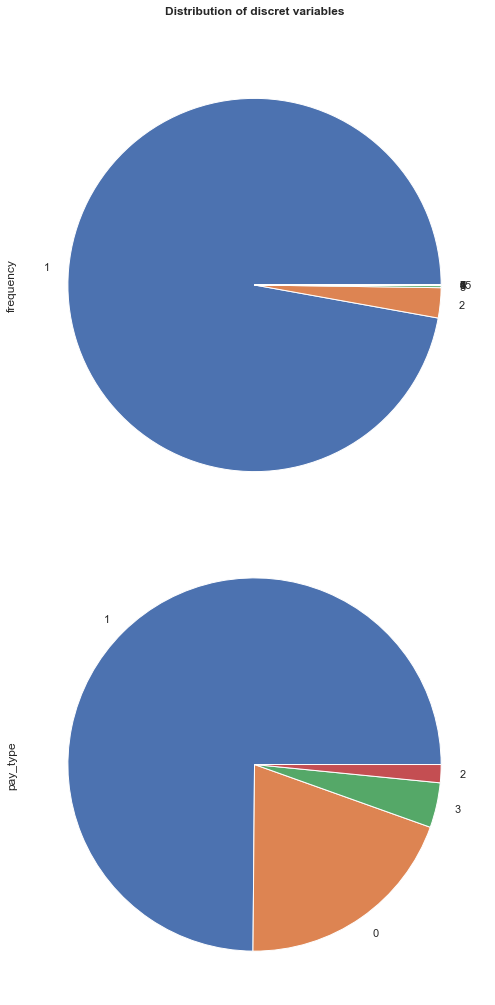

In [65]:
# Analysing order of magnitude of each variable
fig = plt.figure(figsize=(15,15))

for i, col in enumerate(['frequency', 'pay_type'],1):
    ax = fig.add_subplot(2,1,i)
    dataset[col].value_counts().plot(kind='pie')

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.suptitle('Distribution of discret variables', fontsize=12,
             fontweight='bold')

plt.show()

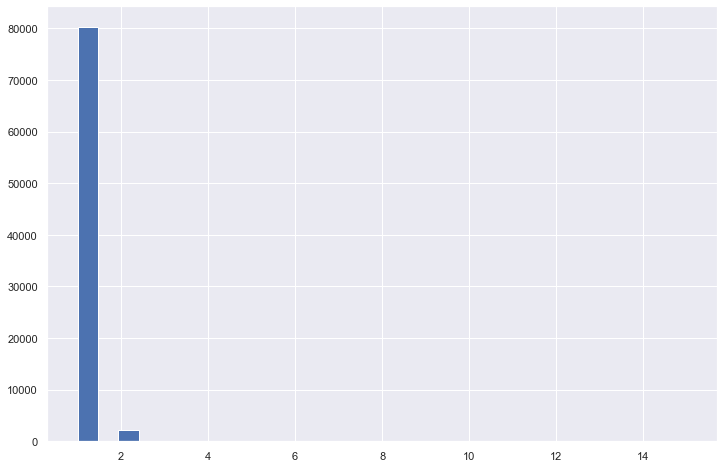

In [66]:
# Visualising with more details the feature frequency
plt.figure(figsize=(12, 8))
plt.hist(dataset['frequency'],  bins=30)
plt.show() 

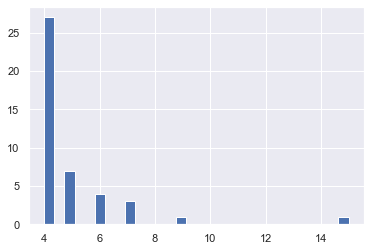

In [67]:
# Visualising (zoomed) of feature frequency
dataset_temp = dataset[dataset['frequency']>3]
plt.hist(dataset_temp['frequency'],  bins=30)
plt.show() 

In [68]:
# Saving cleaned dataset 
dataset_date.to_csv('customers_cleaned.csv', index=False)

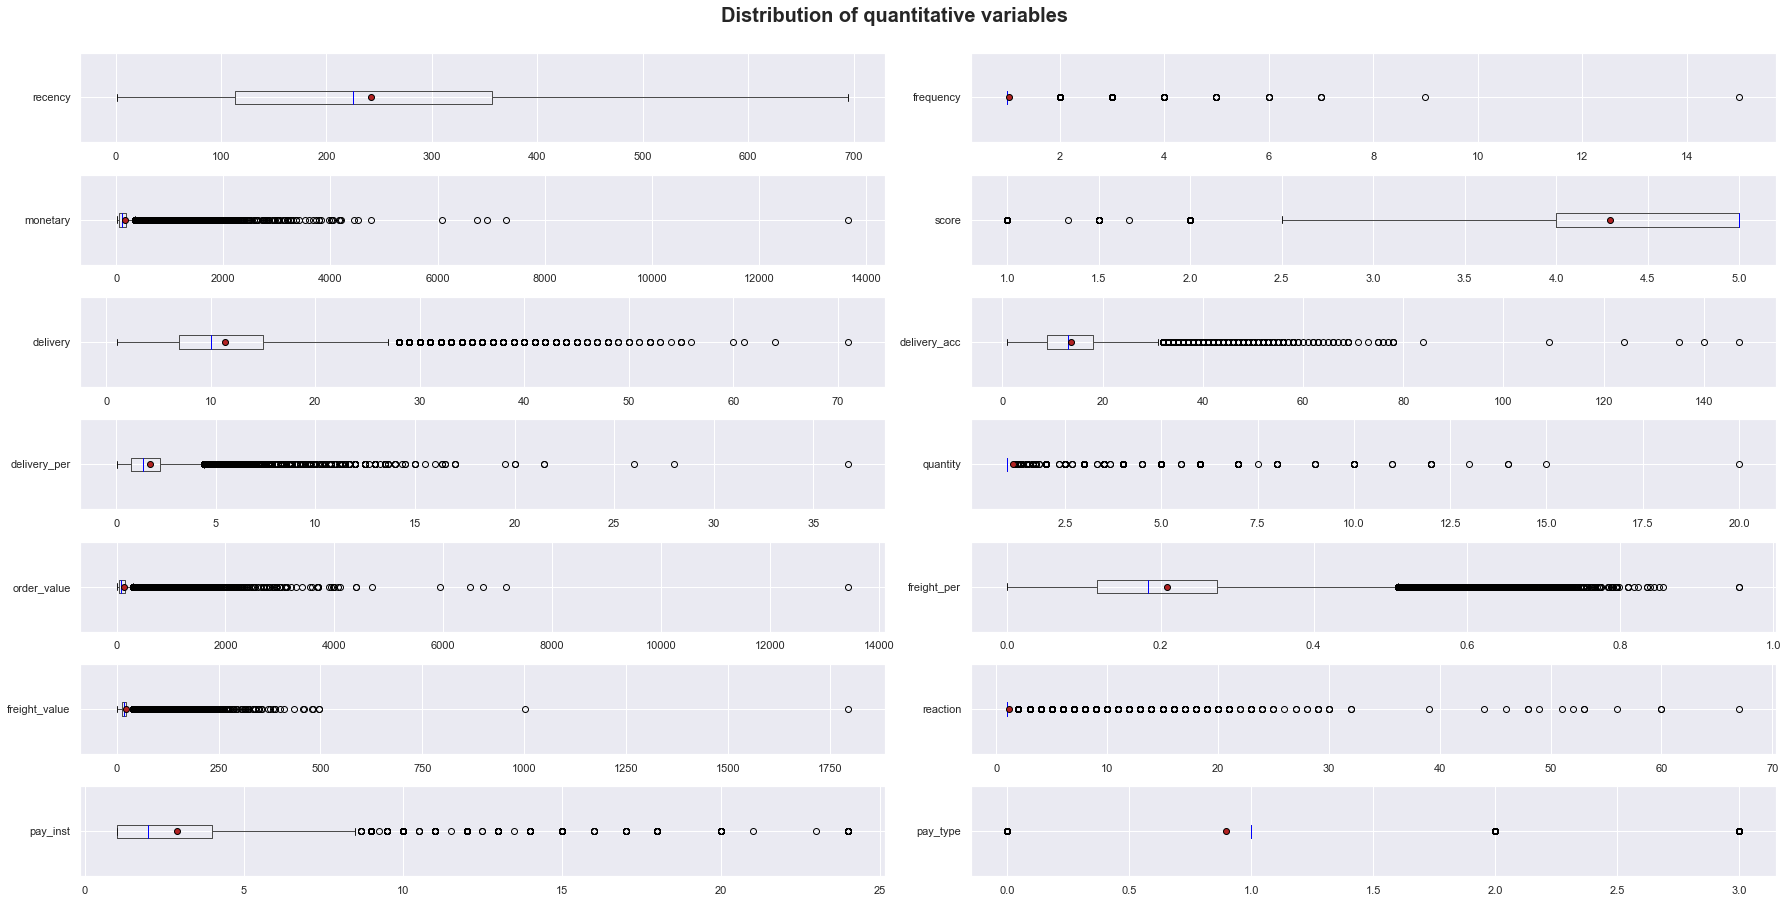

In [69]:
# Analysing order of magnitude for each variable - boxplot
fig = plt.figure(figsize=(25,15))

medianprops = {'color':"blue"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}


for i, col in enumerate(dataset.columns,1):
    ax = fig.add_subplot(8,2,i)
    data_temp = dataset[[col]]
    data_temp.boxplot(showfliers=True, medianprops=medianprops, vert=False, showmeans=True, meanprops=meanprops, ax=ax)
    
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.suptitle('Distribution of quantitative variables', fontsize=20,
             fontweight='bold')

plt.show()

C:\Users\najwa\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\najwa\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\najwa\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

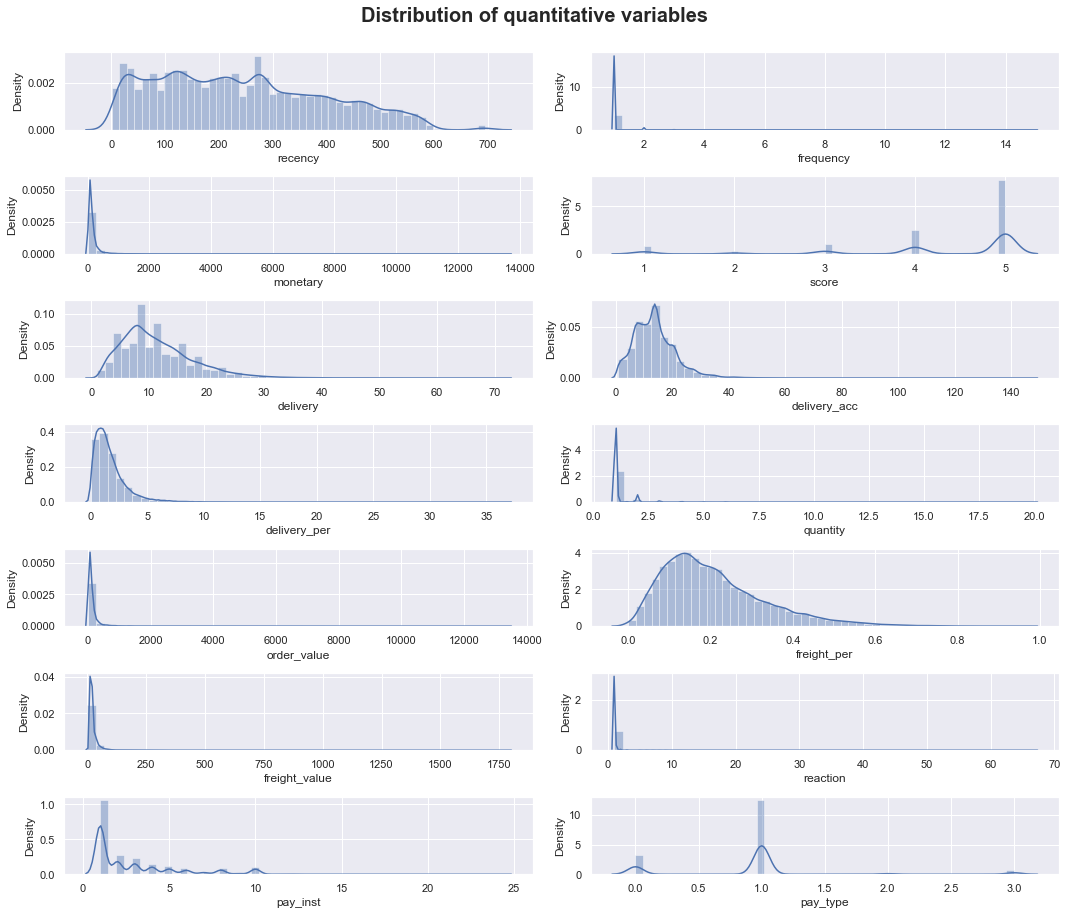

In [70]:
# Analysing order of magnitude for each variable - histogram
fig = plt.figure(figsize=(15,15))

for i, col in enumerate(dataset.columns,1):
    ax = fig.add_subplot(8,2,i)
    #ax.hist(dataset[col],  bins=50)
    sns.distplot(dataset[col])
    #plt.xlabel(col)
    #ax.set_title(col)
    #ax.vlines(dataset[col].median(), *ax.get_ylim(), color='red', ls='-', lw=1.5)
    #ax.vlines(dataset[col].mean(), *ax.get_ylim(),  color='green', ls='-.', lw=1.5)
    #ax.vlines(dataset[col].mode()[0], *ax.get_ylim(), color='yellow', ls='--', lw=1.5)
    #ax.legend(['mediane','moyenne','mode'])

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.suptitle('Distribution of quantitative variables', fontsize=20,
             fontweight='bold')

plt.show()

C:\Users\najwa\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\najwa\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\najwa\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

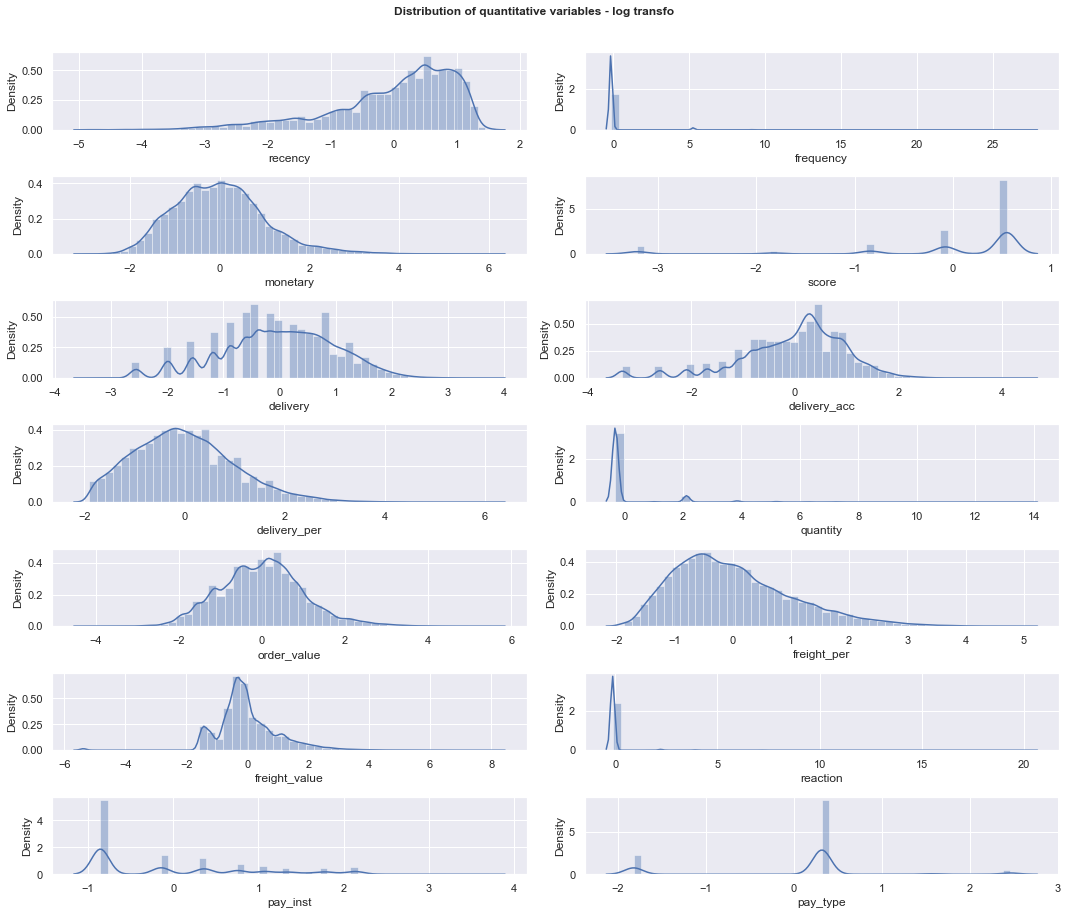

In [71]:
# Analysing order of magnitude for each variable - histogram
dataset_log = dataset.copy()

for c in dataset_log.columns:
    dataset_log[c] = np.log1p(dataset_log[c])

scaler = StandardScaler()
dataset_log = scaler.fit_transform(dataset_log)
dataset_log = DataFrame(dataset_log)
dataset_log.columns = dataset.columns

fig = plt.figure(figsize=(15,15))

for i, col in enumerate(dataset_log.columns,1):
    ax = fig.add_subplot(8,2,i)
    #ax.hist(data[col],  bins=50)
    sns.distplot(dataset_log[col])
    #plt.xlabel(col)
    #ax.set_title(col)
    #ax.vlines(dataset_log[col].median(), *ax.get_ylim(), color='red', ls='-', lw=1.5)
    #ax.vlines(dataset_log[col].mean(), *ax.get_ylim(),  color='green', ls='-.', lw=1.5)
    #ax.vlines(dataset_log[col].mode()[0], *ax.get_ylim(), color='yellow', ls='--', lw=1.5)
    #ax.legend(['mediane','moyenne','mode'])

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.suptitle('Distribution of quantitative variables - log transfo', fontsize=12,
             fontweight='bold')

plt.show()

C:\Users\najwa\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\najwa\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\najwa\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

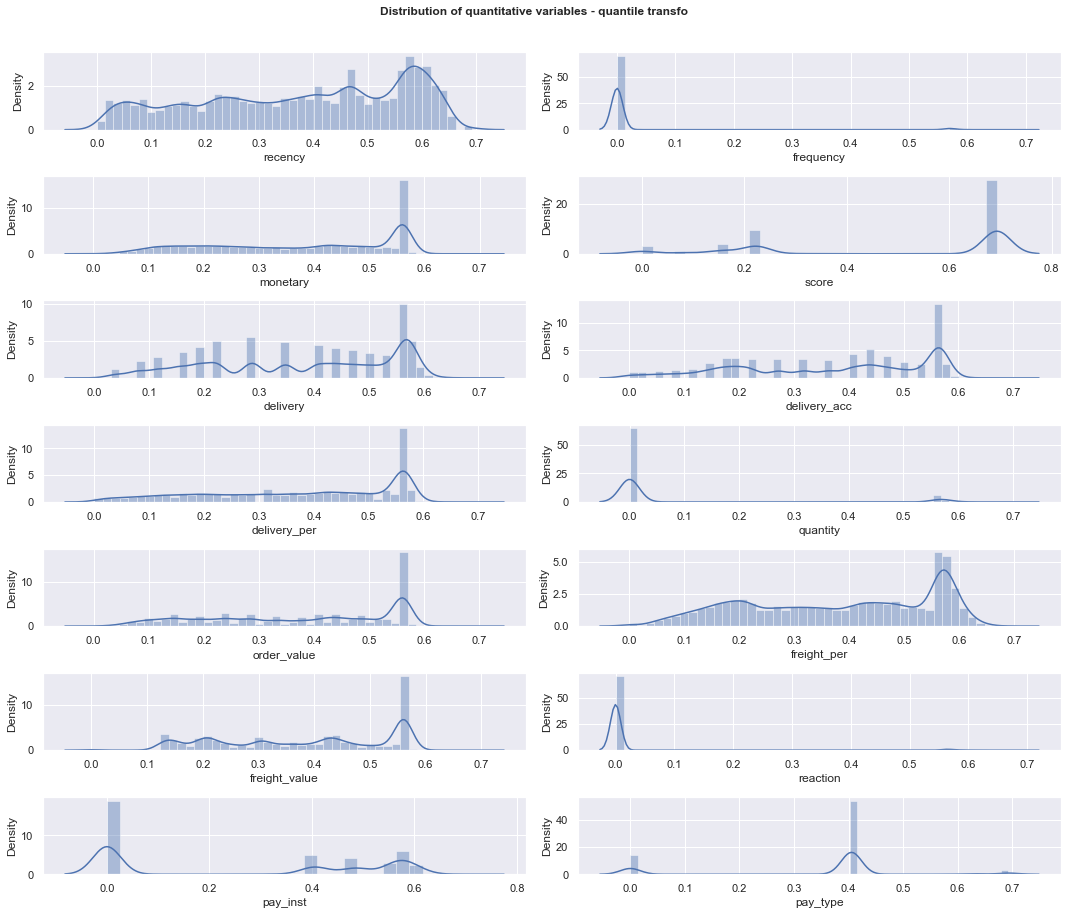

In [72]:
scaler = QuantileTransformer(n_quantiles=5)
dataset_quart = scaler.fit_transform(dataset)
dataset_quart = DataFrame(dataset_quart)
dataset_quart.columns = dataset.columns

# Analysing order of magnitude for each variable - histogram
fig = plt.figure(figsize=(15,15))

for i, col in enumerate(dataset_quart.columns,1):
    ax = fig.add_subplot(8,2,i)
    #ax.hist(data[col],  bins=50)
    sns.distplot(np.log1p(dataset_quart[col]))
    #plt.xlabel(col)
    #ax.set_title(col)
    #ax.vlines(np.log1p(dataset_quart[col]).median(), *ax.get_ylim(), color='red', ls='-', lw=1.5)
    #ax.vlines(np.log1p(dataset_quart[col]).mean(), *ax.get_ylim(),  color='green', ls='-.', lw=1.5)
    #ax.vlines(np.log1p(dataset_quart[col]).mode()[0], *ax.get_ylim(), color='yellow', ls='--', lw=1.5)
    #ax.legend(['mediane','moyenne','mode'])

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.suptitle('Distribution of quantitative variables - quantile transfo', fontsize=12,
             fontweight='bold')

plt.show()

In [73]:
# Copying file log and quant
dataset_log.to_csv('dataset_log.csv', index=False)
dataset_quart.to_csv('dataset_quart.csv', index=False)

# <a name="C13">Correlation between variables</a>

C:\Users\najwa\AppData\Local\Temp\ipykernel_8544\3474942363.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


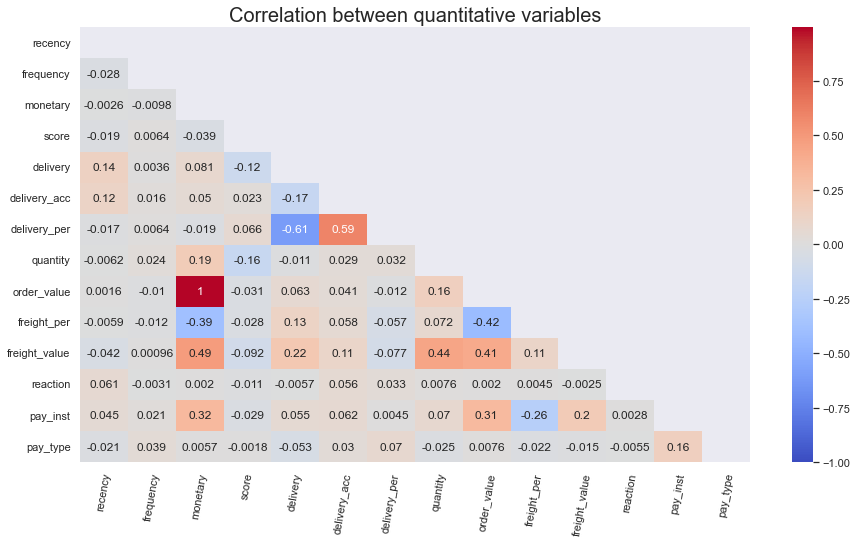

In [74]:
# Displaying heatmap correlation between quantitative variables
plt.figure(figsize=(15,8))
#sns.set(font_scale=1.5)
plt.title('Correlation between quantitative variables', fontsize = 20)

corr = dataset.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True 

ax = sns.heatmap(corr, mask=mask, vmin=-1, cmap='coolwarm', annot = True)
plt.xticks(rotation=80)
plt.show()
sns.set(font_scale=1)

In [75]:
# Analysing with pairplot/pairgrid
#%matplotlib inline
#data_grid = dataset
#sns.pairgrid(data_pair, height=2.5)
#g = sns.PairGrid(data_grid)
#g.map_diag(plt.hist)
#g.map_offdiag(plt.scatter);
#plt.show()

C:\Users\najwa\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


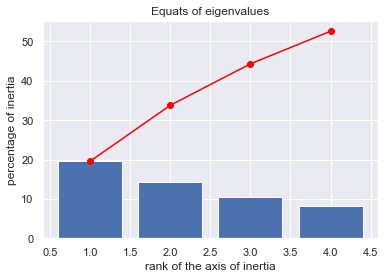

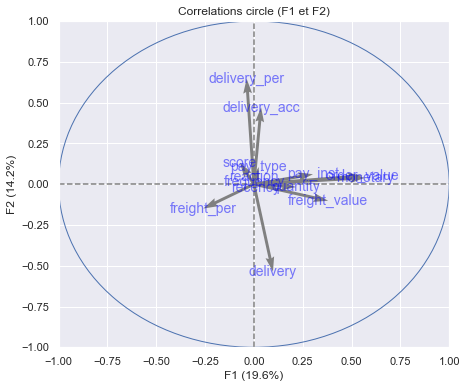

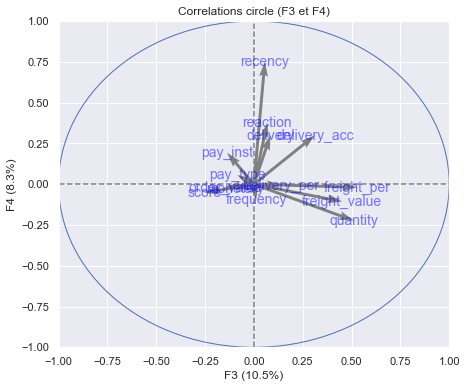

In [76]:
# Performing an ACP
# Chosing 4 components to compute
n_comp = 4

# Selecting columns to consider for PCA
acp_vars = dataset.columns
data_pca = dataset[acp_vars]
data_pca = data_pca.fillna(data_pca.mean())

# Preparing data for PCA
X = data_pca.values
names = data_pca.index 
features = data_pca.columns

# Centering and reducing
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(data_pca[acp_vars])

# Computing main components 
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Decomposing eigenvalues
display_scree_plot(pca)

# Displaying circle of correlations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))

plt.show()

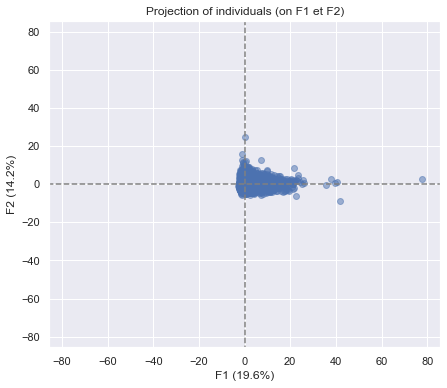

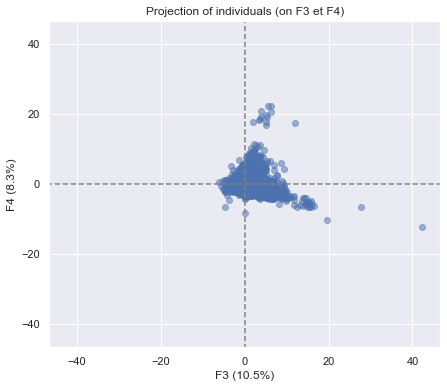

In [77]:
# Projecting individuals
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3)], alpha=.5)
plt.show()

In [78]:
# Displaying pca coefficients matrix 
pcs = pd.DataFrame(pca.components_,
                      index=['PC'+str(i+1) for i in range(n_comp)],
                      columns=data_pca.columns).T
pcs

,PC1,PC2,PC3,PC4
recency,0.009923,-0.025315,0.056287,0.750688
frequency,0.002670,0.017082,0.011878,-0.095656
monetary,0.568617,0.039273,-0.094875,-0.029945
score,-0.070760,0.131773,-0.253212,-0.051900
delivery,0.097695,-0.535710,0.084537,0.298663
delivery_acc,0.036820,0.471428,0.312412,0.299744
delivery_per,-0.037064,0.646752,0.141858,-0.007435
quantity,0.215469,-0.017354,0.511611,-0.223474
order_value,0.555688,0.051513,-0.145866,-0.020596
freight_per,-0.259124,-0.149154,0.528826,-0.019210


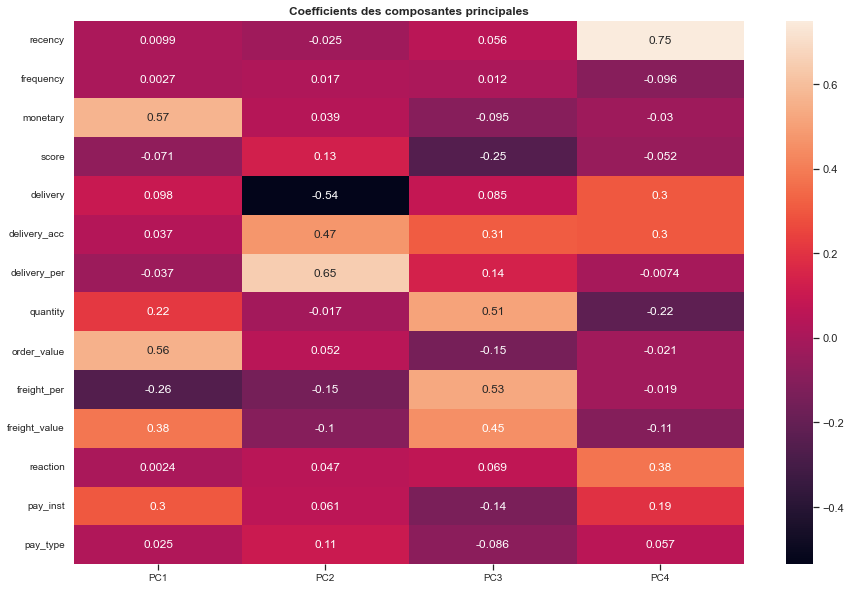

In [79]:
# Visualising this matrix
fig = plt.figure(figsize=(15,10))
sns.heatmap(pcs, annot=True,xticklabels= pcs.columns, yticklabels = pcs.index)
plt.tick_params(labelsize=10,top=False, bottom=True,
                labeltop=False, labelbottom=True)
plt.title("Coefficients des composantes principales", fontweight='bold', fontsize=12)
plt.show()

# <a name="C13">Selection of variables</a>

Generation of 5 files:
- customers_rfms: file limited to RFMS
- customers_rfms_log: file limited to RFMS transformed log 
- customers_rfms_quart: file limited to RFMS transformed quantilescaler
- customers_log: file limited to relevant features transformed log + standardscaler
- customers_quart: file limited to relevant features transformed quantilescaler + tandardscaler

In [80]:
# Generating file rfms
customers_rfms = dataset[['recency','frequency','monetary','score']]
customers_rfms.to_csv('customers_rfms.csv', index=False)

In [81]:
# Generating file rfms_log
customers_rfms_log = dataset_log[['recency','frequency','monetary','score']]
customers_rfms_log.to_csv('customers_rfms_log.csv', index=False)

In [82]:
# Generating file rfms_quart
customers_rfms_quart = dataset_quart[['recency','frequency','monetary','score']]
customers_rfms_quart.to_csv('customers_rfms_quart.csv', index=False)

In [83]:
# Generating file log
customers_log = dataset_log[['score','freight_per','delivery_per','quantity']]
customers_log.to_csv('customers_log.csv', index=False)

In [84]:
# Generating file quart
customers_quart = dataset_quart[['score','freight_per','delivery_per','quantity']]
#customers_quart = dataset_quart.copy()
customers_quart.to_csv('customers_quart.csv', index=False)

The end of analysis